In [1]:
import os 
import pickle

import yaml
import dataclasses
from typing import Optional


@dataclasses.dataclass
class Request:
    req_id: str
    prompt: str
    prompt_len: int
    output_len: int
    arrival_time: float
    model: str
    slo: Optional[float] = None


class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if name == "Request":
            return Request
        return super().find_class(module, name)


class RealWorldTrace:
    def __init__(self, pkl_file_path):
        self.pkl_file_path = pkl_file_path
        self.requests = []
        self._load_requests()

    def _load_requests(self):
        if os.path.exists(self.pkl_file_path):
            with open(self.pkl_file_path, "rb") as pkl_file:
                obj = CustomUnpickler(pkl_file).load()
            adapter_dirs, self.requests = obj[0], obj[1]
        else:
            raise FileNotFoundError(f"File {self.pkl_file_path} not found")
        
    def process_requests(self):
        print(f"Processing {len(self.requests)} requests")
        processed_requests = [] 
        for req in self.requests:
            processed_request = Request(
                req_id=req.req_id,
                prompt=req.prompt,
                prompt_len=req.prompt_len,
                output_len=req.output_len,
                arrival_time=req.req_time,
                model=f"{req.model_dir}/{req.adapter_dir}",
                slo=100,
            )
            processed_requests.append(processed_request)
        return processed_requests
    
    def generate_micro_benchmark_reqs(self, config):
        model_mapping = {
            0: "model_1",  # collocate model 0
            10: "model_2",  # collocate model 1
            14: "model_3",  # swap model 0
            20: "model_4",  # swap model 1
        }
        time_scale = config.time_scale
        replication = config.replication
        assert config.micro_benchmark

        max_req_id = max([int(req.req_id) for req in self.requests])
        selected_requests = []
        for req in self.requests:
            req_rank = int(req.adapter_dir.split("-")[-1])
            if req_rank in model_mapping:
                for i in range(replication):
                    processed_request = Request(
                        req_id=str(req.req_id + i * max_req_id),
                        prompt=req.prompt,
                        prompt_len=req.prompt_len,
                        output_len=req.output_len,
                        arrival_time=req.req_time * time_scale,
                        model=model_mapping[req_rank],
                        slo=config.slo,
                    )
                    selected_requests.append(processed_request)

        return selected_requests
    
    def generate_e2e_benchmark_reqs(self, config):
        assert config.e2e_benchmark
        time_scale = config.time_scale
        replication = config.replication

        selected_ranks = [2, 14, 3, 10, 5, 19, 23, 24]
        model_mapping = {rank: f"model_{i+1}" for i, rank in enumerate(selected_ranks)}
        model_paths = {
            "model_1": "mistralai/Mistral-Nemo-Instruct-2407",
            "model_2": "mistralai/Mistral-Nemo-Instruct-2407",
            "model_3": "meta-llama/Meta-Llama-3.1-8B",
            "model_4": "mistralai/Mistral-Nemo-Instruct-2407",
            "model_5": "mistralai/Mistral-7B-Instruct-v0.2",
            "model_6": "mistralai/Mistral-7B-Instruct-v0.2",
            "model_7": "meta-llama/Llama-3.2-3B",
            "model_8": "meta-llama/Llama-3.2-3B",
        }
        selected_requests = []
        for req in self.requests:
            req_rank = int(req.adapter_dir.split("-")[-1])
            if req_rank in selected_ranks:
                for i in range(replication):
                    processed_request = Request(
                        req_id=str(req.req_id + i * 2000),
                        prompt=req.prompt,
                        prompt_len=req.prompt_len,
                        output_len=req.output_len,
                        arrival_time=req.req_time * time_scale,
                        model=model_mapping[req_rank],
                        slo=config.slo,
                    )
                    selected_requests.append(processed_request)
        return selected_requests


In [2]:
from figplot import plot_requests_per_second_in_bins

Processing 1500 requests


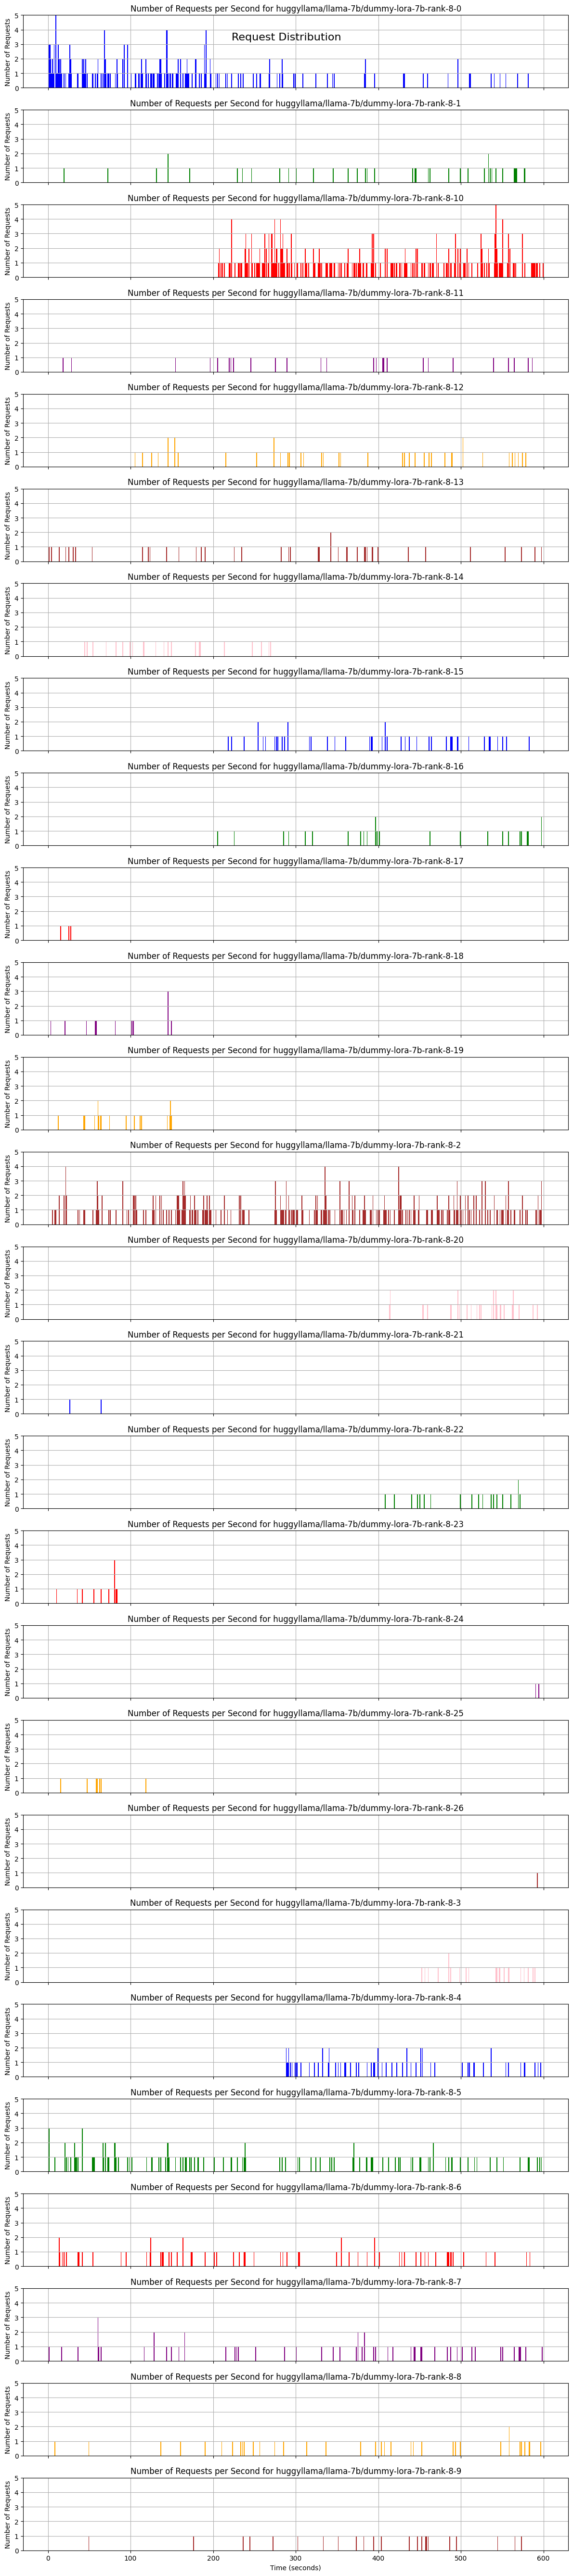

In [3]:
all_requests = RealWorldTrace(pkl_file_path="real_trace.pkl").process_requests()
plot_requests_per_second_in_bins(all_requests, trace_config=None, if_save=False)

In [4]:
micro_requests = RealWorldTrace(pkl_file_path="real_trace.pkl").generate_micro_benchmark_reqs(config=None, time_scale=0.2)
plot_requests_per_second_in_bins(micro_requests, trace_config=None, if_save=False)


TypeError: RealWorldTrace.generate_micro_benchmark_reqs() got an unexpected keyword argument 'time_scale'

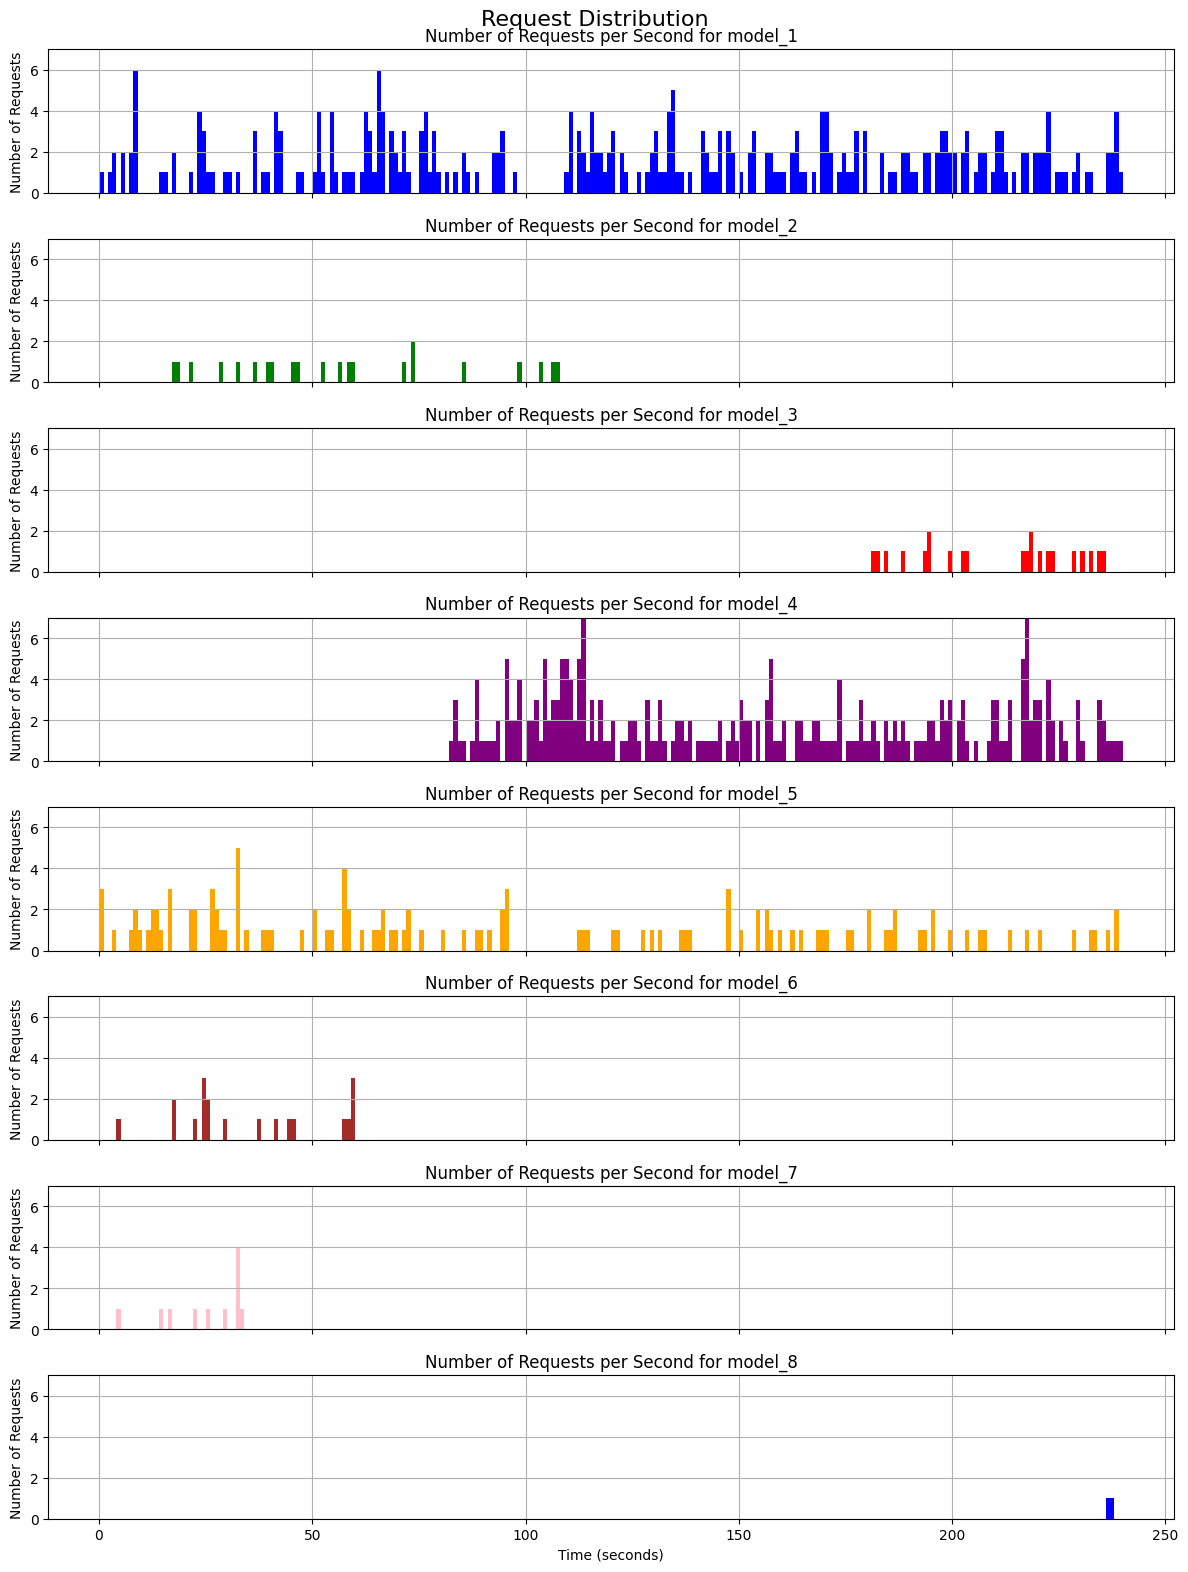

In [6]:
e2e_requests = RealWorldTrace(pkl_file_path="real_trace.pkl").generate_e2e_benchmark_reqs(config=None, time_scale=0.4)
plot_requests_per_second_in_bins(e2e_requests, trace_config=None)

In [16]:
import json
import numpy as np

def dummy_prompt(input_len: int):
    return "a" * input_len

class HyperbolicTrace:
    def __init__(self, json_file_path: Optional[str] = None):
        if json_file_path is None:
            current_dir = os.path.dirname(os.path.abspath(__file__))
            self.json_file_path = os.path.join(current_dir, "hyperbolic_trace.json")
        else:
            self.json_file_path = json_file_path

        self.prompt_range = [8, 512]
        self.output_range = [8, 512]
        self._load_requests()

    def _load_requests(self):
        if os.path.exists(self.json_file_path):
            with open(self.json_file_path, "r") as json_file:
                data = json.load(json_file)
            # data is like [{'time': 0.0, 'model': 1}, {'time': 0.314301, 'model': 2}, ...]
            self.requests = data
        else:
            raise FileNotFoundError(f"File {self.json_file_path} not found")
        
    def generate_e2e_benchmark_reqs(self, config):
        assert config.e2e_benchmark
        time_scale = config.time_scale
        replication = config.replication

        req_count = 0
        selected_requests = []

        input_lens = np.random.randint(*self.prompt_range, len(self.requests))
        output_lens = np.random.randint(*self.output_range, len(self.requests))
    
        for req in self.requests:
            for i in range(replication):
                processed_request = Request(
                    req_id=str(req_count),
                    prompt=dummy_prompt(input_lens[i]),
                    prompt_len=int(input_lens[i]),
                    output_len=int(output_lens[i]),
                    arrival_time=req["time"] * time_scale,
                    model=req["model"],
                    slo=config.slo,
                )
                selected_requests.append(processed_request)
                req_count += 1
        return selected_requests

In [10]:

@dataclasses.dataclass
class TraceConfig:
    micro_benchmark: bool = False
    e2e_benchmark: bool = False
    synthetic: bool = False
    # for micro benchmark and e2e benchmark
    replication: int = 1
    time_scale: float = 1

    model_paths: list[str] = dataclasses.field(default_factory=list)
    req_rate: float = 2
    duration: float = 60
    input_range: tuple[int, int] = (8, 512)
    output_range: tuple[int, int] = (8, 512)
    seed: int = 42
    tokenizer_paths: Optional[list[str]] = None

    # for synthetic requests
    alpha: Optional[float] = None
    cv: Optional[float] = None
    sequential: Optional[bool] = False
    start_index: Optional[int] = 0
    # on off
    on_off_cycle_len: Optional[int] = -1  # the time of each cycle (on+off)
    off_ratio: Optional[float] = 0.5  # the ratio of off time in each cycle
    on_off_model_percentage: Optional[float] = (
        0  # the percentage of models among all the models that follow the on_off pattern
    )

    # slo
    slo: Optional[float] = None

    def __post_init__(self):
        if self.alpha is None:
            self.alpha = 0.1
        if self.cv is None:
            self.cv = 1
        if self.tokenizer_paths is None:
            self.tokenizer_paths = self.model_paths


In [12]:
import numpy as np

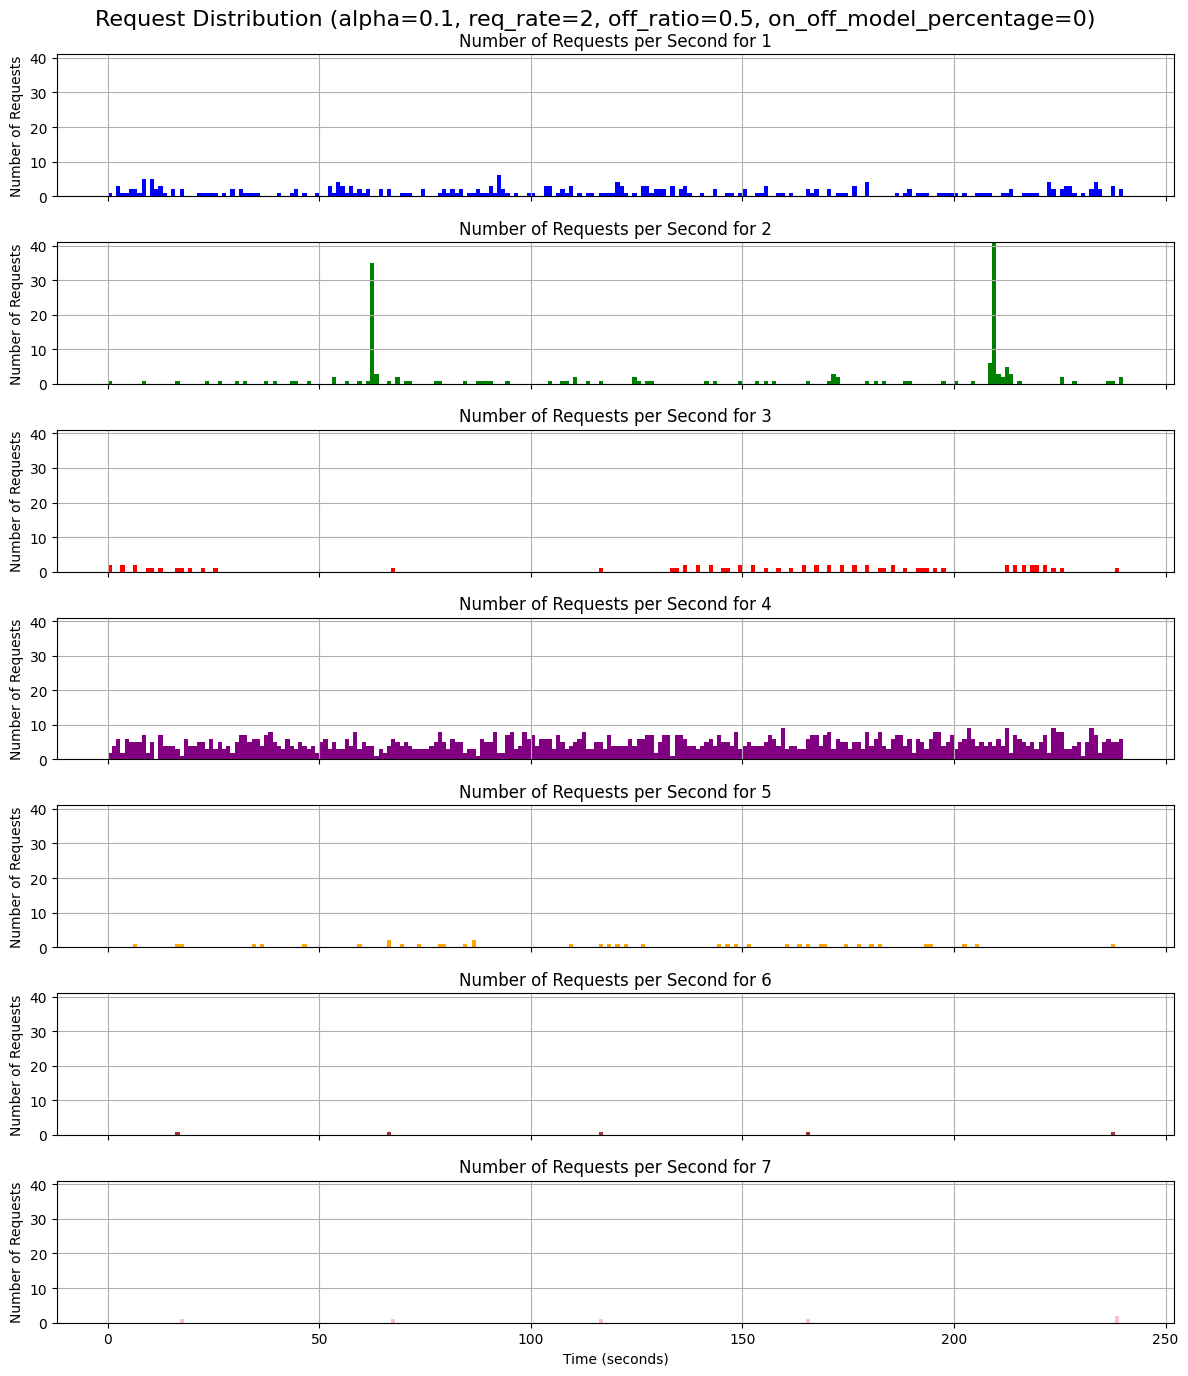

In [17]:
trace_config = TraceConfig(e2e_benchmark=True, time_scale=0.4, replication=1)

hyperbolic_requests = HyperbolicTrace(json_file_path="hyperbolic_trace.json").generate_e2e_benchmark_reqs(config=trace_config)
plot_requests_per_second_in_bins(hyperbolic_requests, trace_config=trace_config)